# 03 - Training & Evaluation

**Objectif**: Entraîner et évaluer différents modèles de classification pour prédire le gagnant d'un combat Pokémon 1v1.

**Input**: Features préparées dans `data/ml/battle_winner/features/`

**Output**: Modèle entraîné exporté dans `models/`

**Date**: 2026-01-21

---

## Table des Matières

1. [Chargement des Données](#1-chargement-des-données)
2. [Baseline: Logistic Regression](#2-baseline-logistic-regression)
3. [Random Forest](#3-random-forest)
4. [XGBoost](#4-xgboost)
5. [Comparaison des Modèles](#5-comparaison-des-modèles)
6. [Analyse des Feature Importances](#6-analyse-des-feature-importances)
7. [Export du Modèle Final](#7-export-du-modèle-final)
8. [Conclusion](#8-conclusion)

## 1. Chargement des Données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost non installé, utilisation de Random Forest uniquement")

# Configuration
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# Chemins
BASE_DIR = Path('../data/ml/battle_winner')
FEATURES_DIR = BASE_DIR / 'features'
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

# Seed pour reproductibilité
RANDOM_STATE = 42

print("📦 Bibliothèques chargées")
print(f"   XGBoost disponible: {XGBOOST_AVAILABLE}")

📦 Bibliothèques chargées
   XGBoost disponible: True


In [2]:
# Chargement des features
X_train = pd.read_parquet(FEATURES_DIR / 'X_train.parquet')
X_test = pd.read_parquet(FEATURES_DIR / 'X_test.parquet')
y_train = pd.read_parquet(FEATURES_DIR / 'y_train.parquet')['winner']
y_test = pd.read_parquet(FEATURES_DIR / 'y_test.parquet')['winner']

print(f"✅ Données chargées")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape} | Distribution: {y_train.value_counts().to_dict()}")
print(f"   y_test: {y_test.shape} | Distribution: {y_test.value_counts().to_dict()}")

✅ Données chargées
   X_train: (27232, 133)
   X_test: (6808, 133)
   y_train: (27232,) | Distribution: {1: 13619, 0: 13613}
   y_test: (6808,) | Distribution: {1: 3405, 0: 3403}


In [3]:
# Dictionnaire pour stocker les résultats
results = {}

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Entraîne et évalue un modèle.
    Retourne un dictionnaire avec les métriques.
    """
    print(f"\n{'='*80}")
    print(f"🤖 {model_name}")
    print(f"{'='*80}")
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"⏱️ Temps d'entraînement: {train_time:.2f}s")
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métriques Train
    train_acc = accuracy_score(y_train, y_pred_train)
    
    # Métriques Test
    test_acc = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None
    
    print(f"\n📊 Résultats:")
    print(f"   Train Accuracy: {train_acc:.4f}")
    print(f"   Test Accuracy:  {test_acc:.4f}")
    print(f"   Test Precision: {test_precision:.4f}")
    print(f"   Test Recall:    {test_recall:.4f}")
    print(f"   Test F1-Score:  {test_f1:.4f}")
    if test_roc_auc:
        print(f"   Test ROC-AUC:   {test_roc_auc:.4f}")
    
    # Overfitting check
    overfit_gap = train_acc - test_acc
    if overfit_gap > 0.05:
        print(f"   ⚠️ Overfitting détecté (gap: {overfit_gap:.4f})")
    else:
        print(f"   ✅ Pas d'overfitting significatif (gap: {overfit_gap:.4f})")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_time': train_time,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_pred_test': y_pred_test,
        'y_proba_test': y_proba_test
    }

print("✅ Fonction d'évaluation définie")

✅ Fonction d'évaluation définie


## 2. Baseline: Logistic Regression

In [4]:
# Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='lbfgs',
    n_jobs=-1
)

results['Logistic Regression'] = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, 'Logistic Regression'
)


🤖 Logistic Regression
⏱️ Temps d'entraînement: 1.38s

📊 Résultats:
   Train Accuracy: 0.9083
   Test Accuracy:  0.9088
   Test Precision: 0.9135
   Test Recall:    0.9031
   Test F1-Score:  0.9083
   Test ROC-AUC:   0.9713
   ✅ Pas d'overfitting significatif (gap: -0.0004)


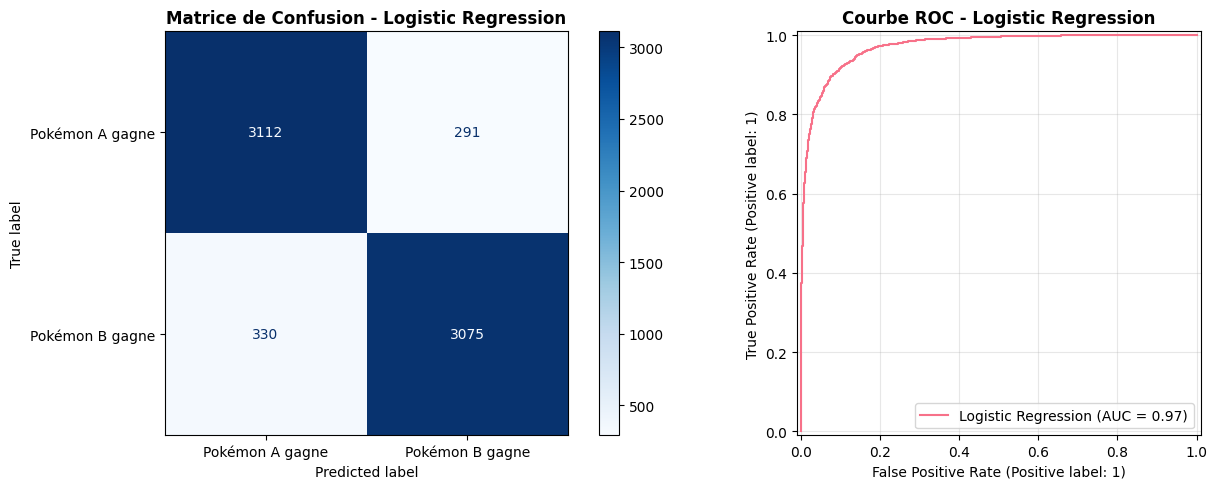

In [5]:
# Matrice de confusion - Logistic Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, results['Logistic Regression']['y_pred_test'],
    display_labels=['Pokémon A gagne', 'Pokémon B gagne'],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title('Matrice de Confusion - Logistic Regression', fontsize=12, fontweight='bold')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, results['Logistic Regression']['y_proba_test'],
    ax=axes[1], name='Logistic Regression'
)
axes[1].set_title('Courbe ROC - Logistic Regression', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Random Forest

In [6]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

results['Random Forest'] = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, 'Random Forest'
)


🤖 Random Forest
⏱️ Temps d'entraînement: 0.41s

📊 Résultats:
   Train Accuracy: 0.9928
   Test Accuracy:  0.9348
   Test Precision: 0.9343
   Test Recall:    0.9354
   Test F1-Score:  0.9348
   Test ROC-AUC:   0.9859
   ⚠️ Overfitting détecté (gap: 0.0581)


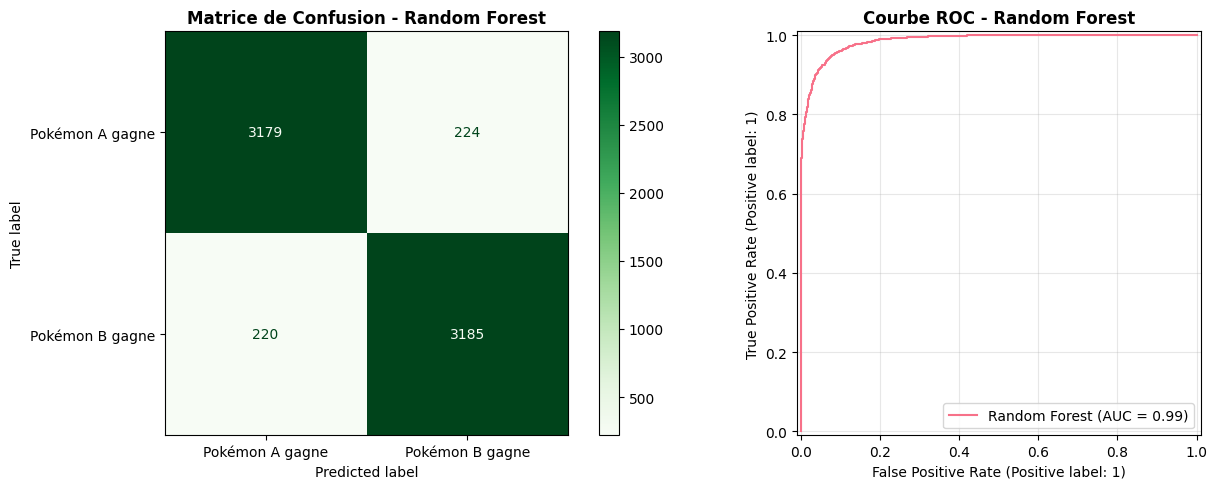

In [7]:
# Matrice de confusion - Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, results['Random Forest']['y_pred_test'],
    display_labels=['Pokémon A gagne', 'Pokémon B gagne'],
    cmap='Greens', ax=axes[0]
)
axes[0].set_title('Matrice de Confusion - Random Forest', fontsize=12, fontweight='bold')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, results['Random Forest']['y_proba_test'],
    ax=axes[1], name='Random Forest'
)
axes[1].set_title('Courbe ROC - Random Forest', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. XGBoost

In [8]:
if XGBOOST_AVAILABLE:
    # XGBoost
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    results['XGBoost'] = evaluate_model(
        xgb_model, X_train, X_test, y_train, y_test, 'XGBoost'
    )
else:
    print("⚠️ XGBoost non disponible, passage à la section suivante")


🤖 XGBoost
⏱️ Temps d'entraînement: 0.52s

📊 Résultats:
   Train Accuracy: 0.9887
   Test Accuracy:  0.9424
   Test Precision: 0.9427
   Test Recall:    0.9421
   Test F1-Score:  0.9424
   Test ROC-AUC:   0.9896
   ✅ Pas d'overfitting significatif (gap: 0.0463)


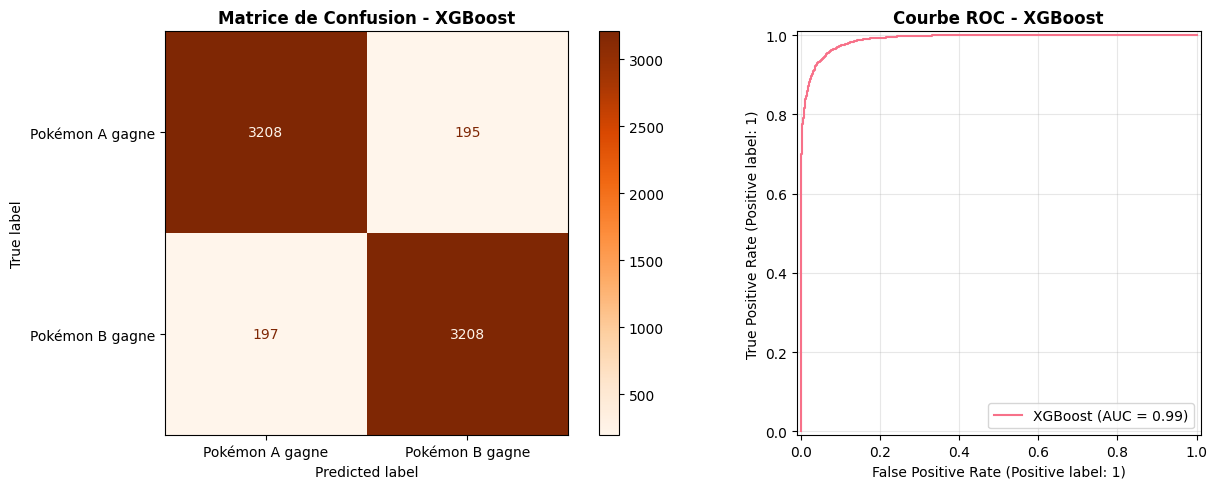

In [9]:
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    # Matrice de confusion - XGBoost
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, results['XGBoost']['y_pred_test'],
        display_labels=['Pokémon A gagne', 'Pokémon B gagne'],
        cmap='Oranges', ax=axes[0]
    )
    axes[0].set_title('Matrice de Confusion - XGBoost', fontsize=12, fontweight='bold')
    
    # ROC Curve
    RocCurveDisplay.from_predictions(
        y_test, results['XGBoost']['y_proba_test'],
        ax=axes[1], name='XGBoost'
    )
    axes[1].set_title('Courbe ROC - XGBoost', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Comparaison des Modèles

In [10]:
# Créer un DataFrame de comparaison
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Train Accuracy': res['train_accuracy'],
        'Test Accuracy': res['test_accuracy'],
        'Precision': res['test_precision'],
        'Recall': res['test_recall'],
        'F1-Score': res['test_f1'],
        'ROC-AUC': res['test_roc_auc'],
        'Train Time (s)': res['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("=" * 80)
print("📊 COMPARAISON DES MODÈLES")
print("=" * 80)
print(comparison_df.to_string(index=False))

📊 COMPARAISON DES MODÈLES
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
            XGBoost        0.988690       0.942421   0.942698 0.942144  0.942421 0.989595        0.523923
      Random Forest        0.992839       0.934783   0.934292 0.935389  0.934840 0.985852        0.406264
Logistic Regression        0.908343       0.908784   0.913547 0.903084  0.908285 0.971278        1.384664


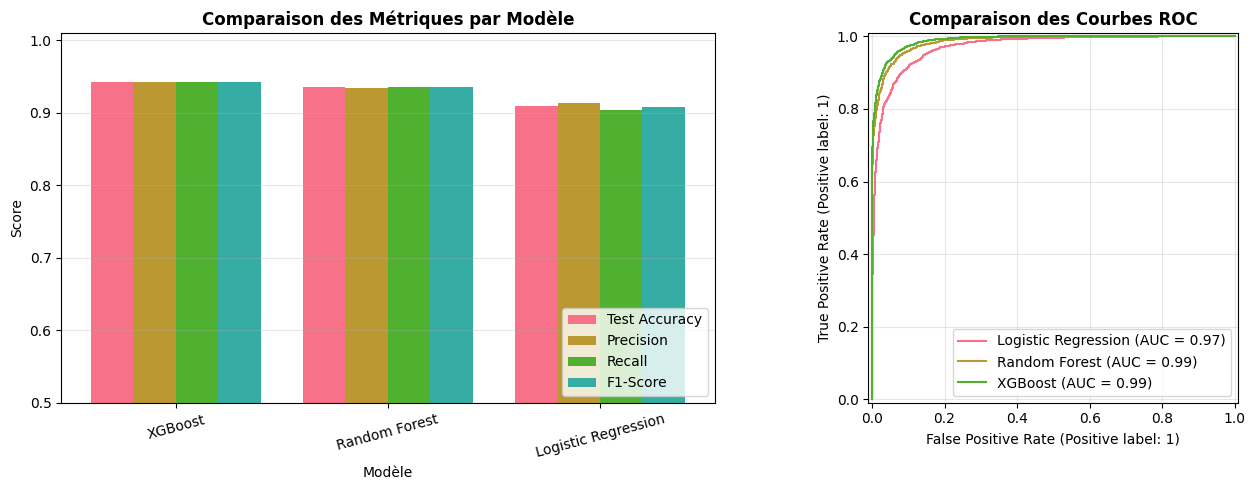

In [11]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot des métriques
metrics_to_plot = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Métriques par Modèle', fontsize=12, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.5, 1.01)
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves comparées
for name, res in results.items():
    if res['y_proba_test'] is not None:
        RocCurveDisplay.from_predictions(
            y_test, res['y_proba_test'],
            ax=axes[1], name=name
        )

axes[1].set_title('Comparaison des Courbes ROC', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Analyse des Feature Importances

In [12]:
# Feature importances du Random Forest
print("=" * 80)
print("🔍 FEATURE IMPORTANCES - Random Forest")
print("=" * 80)

feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results['Random Forest']['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 25 Features:")
print(feature_importance_rf.head(25).to_string(index=False))

🔍 FEATURE IMPORTANCES - Random Forest

Top 25 Features:
             Feature  Importance
          stat_ratio    0.150097
effective_power_diff    0.089959
             hp_diff    0.087903
       a_total_stats    0.053056
       b_total_stats    0.045847
                a_hp    0.044420
                b_hp    0.042890
           b_defense    0.035736
   effective_power_a    0.035393
           a_defense    0.034406
   effective_power_b    0.033568
            b_attack    0.032127
            a_attack    0.030372
        a_sp_defense    0.030228
        b_sp_defense    0.025886
         b_sp_attack    0.021213
         a_sp_attack    0.017565
          speed_diff    0.016776
        b_move_power    0.014825
        a_move_power    0.013815
 type_advantage_diff    0.012641
             a_speed    0.012429
             b_speed    0.012236
    b_move_type_mult    0.006300
    a_move_type_mult    0.006063


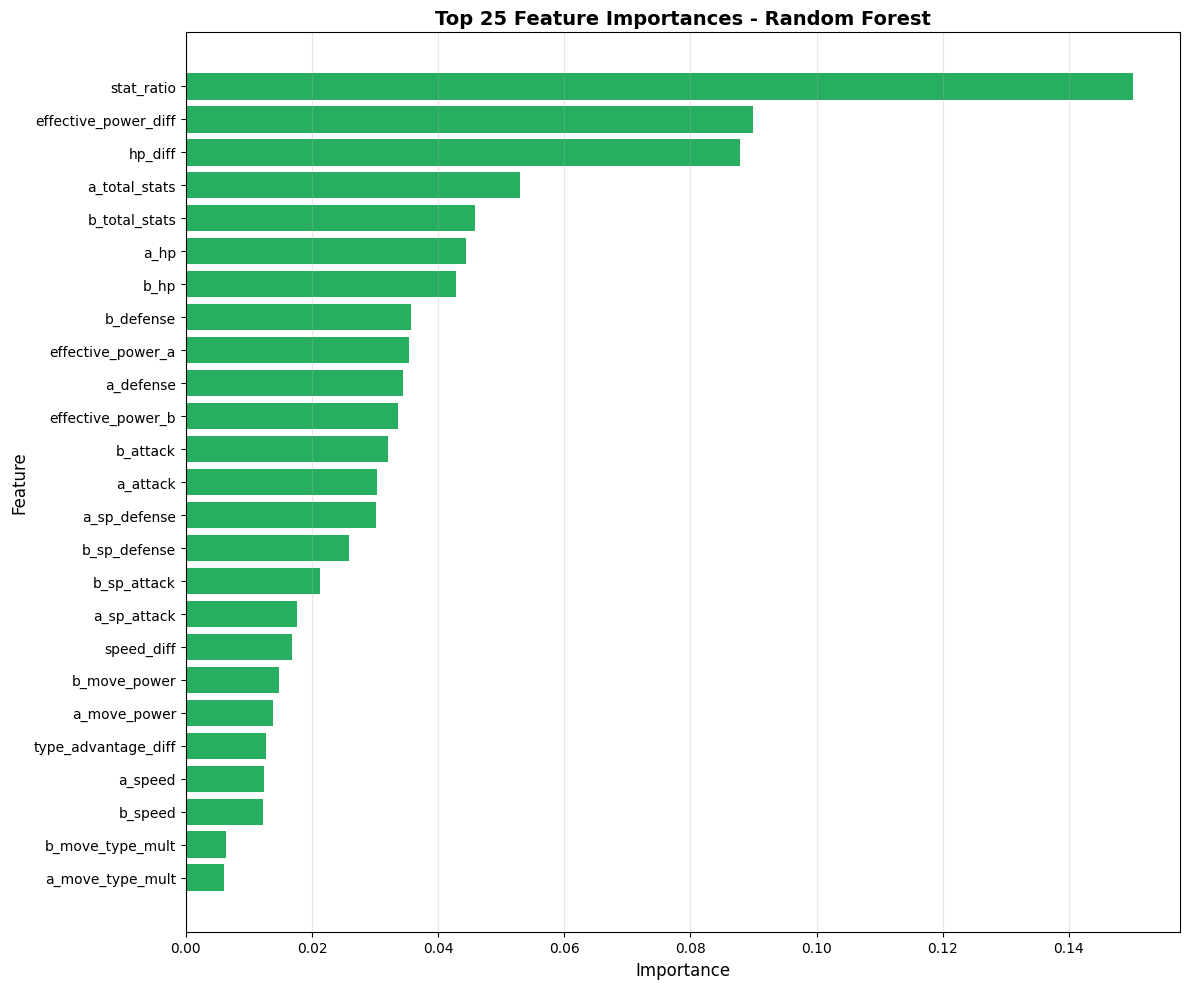


🎯 Feature la plus importante: stat_ratio (0.1501)


In [13]:
# Visualisation des feature importances
fig, ax = plt.subplots(figsize=(12, 10))

top_25_features = feature_importance_rf.head(25)
ax.barh(top_25_features['Feature'], top_25_features['Importance'], color='#27ae60')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 25 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Observation clé
top_feature = feature_importance_rf.iloc[0]
print(f"\n🎯 Feature la plus importante: {top_feature['Feature']} ({top_feature['Importance']:.4f})")


🔍 FEATURE IMPORTANCES - XGBoost

Top 25 Features:
             Feature  Importance
          stat_ratio    0.083737
             hp_diff    0.048136
effective_power_diff    0.037919
       a_moves_first    0.029489
        a_type_2_Fée    0.021737
   effective_power_b    0.020454
       b_total_stats    0.014722
   effective_power_a    0.014328
   b_type_1_Électrik    0.013849
           a_defense    0.012375
          speed_diff    0.012347
                a_hp    0.011911
   a_type_1_Électrik    0.011698
    b_type_1_Spectre    0.011656
    a_type_1_Spectre    0.011346
           b_defense    0.011162
    a_move_type_mult    0.010566
      b_type_1_Roche    0.010101
        a_move_power    0.009221
 a_move_type_Insecte    0.009009
             b_speed    0.008768
            a_attack    0.008721
  b_move_type_Plante    0.008636
  a_move_type_Plante    0.008349
                b_hp    0.008329


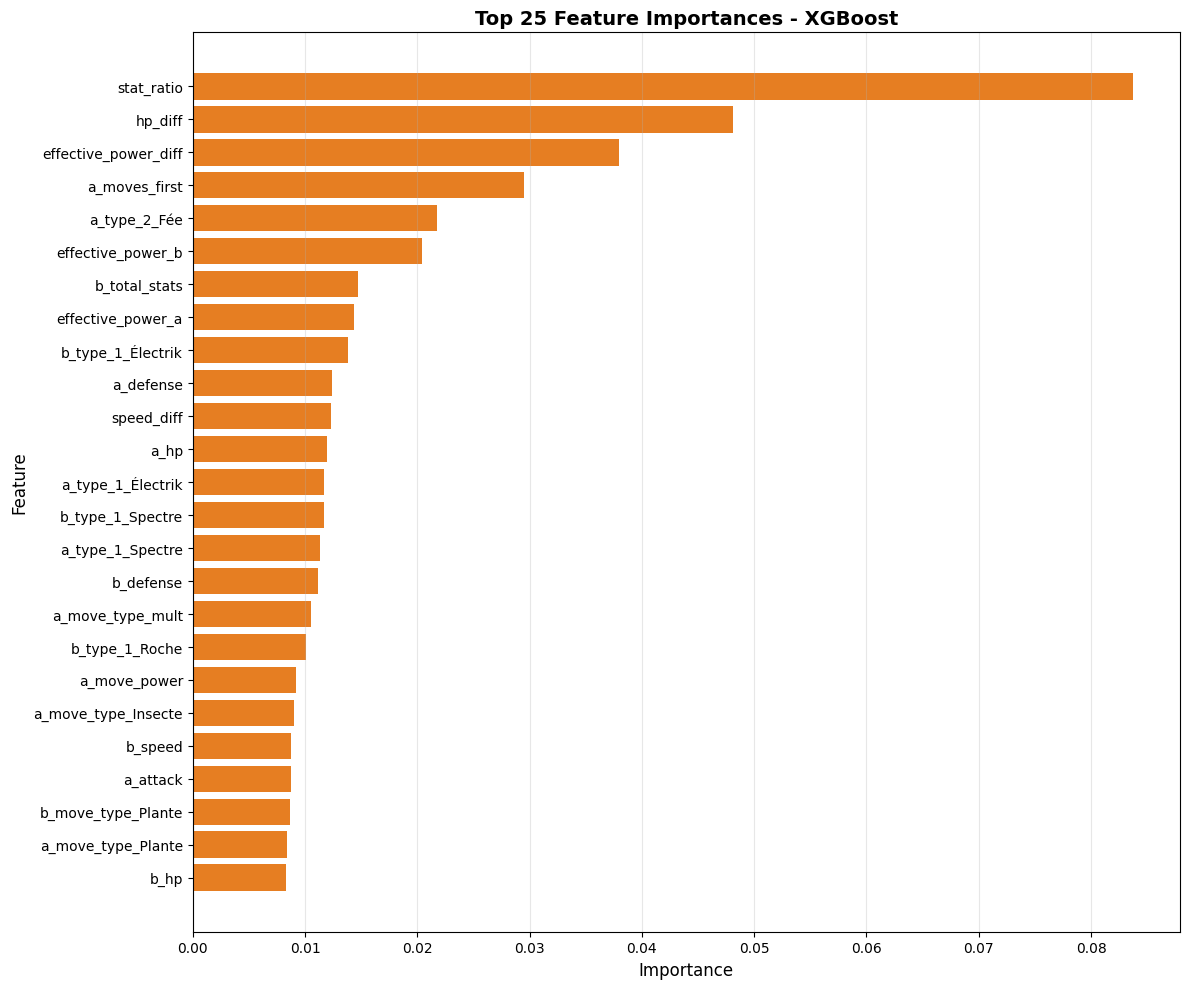

In [14]:
# Feature importances XGBoost (si disponible)
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    print("\n" + "=" * 80)
    print("🔍 FEATURE IMPORTANCES - XGBoost")
    print("=" * 80)
    
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': results['XGBoost']['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 25 Features:")
    print(feature_importance_xgb.head(25).to_string(index=False))
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 10))
    top_25_xgb = feature_importance_xgb.head(25)
    ax.barh(top_25_xgb['Feature'], top_25_xgb['Importance'], color='#e67e22')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Top 25 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Export du Modèle Final

Sélection et export du meilleur modèle pour la production.

In [15]:
# Sélection du meilleur modèle
print("=" * 80)
print("🏆 SÉLECTION DU MODÈLE FINAL")
print("=" * 80)

# Le meilleur modèle basé sur F1-Score
best_model_name = max(results, key=lambda x: results[x]['test_f1'])
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print(f"\n✅ Meilleur modèle: {best_model_name}")
print(f"   Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   Test F1-Score: {best_metrics['test_f1']:.4f}")
print(f"   Test ROC-AUC: {best_metrics['test_roc_auc']:.4f}")

🏆 SÉLECTION DU MODÈLE FINAL

✅ Meilleur modèle: XGBoost
   Test Accuracy: 0.9424
   Test F1-Score: 0.9424
   Test ROC-AUC: 0.9896


In [16]:
# Export des modèles
print("\n" + "=" * 80)
print("💾 EXPORT DES MODÈLES")
print("=" * 80)

# Modèle principal
model_filename = 'battle_winner_model_v1.pkl'
model_path = MODELS_DIR / model_filename
joblib.dump(best_model, model_path)
print(f"\n✅ Modèle principal exporté: {model_path}")

# Random Forest (backup)
rf_path = MODELS_DIR / 'battle_winner_rf_v1.pkl'
joblib.dump(results['Random Forest']['model'], rf_path)
print(f"✅ Random Forest exporté: {rf_path}")

# XGBoost (si disponible)
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    xgb_path = MODELS_DIR / 'battle_winner_xgb_v1.pkl'
    joblib.dump(results['XGBoost']['model'], xgb_path)
    print(f"✅ XGBoost exporté: {xgb_path}")


💾 EXPORT DES MODÈLES

✅ Modèle principal exporté: ../models/battle_winner_model_v1.pkl
✅ Random Forest exporté: ../models/battle_winner_rf_v1.pkl
✅ XGBoost exporté: ../models/battle_winner_xgb_v1.pkl


In [17]:
# Métadonnées du modèle
model_metadata = {
    'model_name': best_model_name,
    'model_file': model_filename,
    'version': 'v1',
    'task': 'battle_winner_prediction',
    'features': X_train.columns.tolist(),
    'n_features': len(X_train.columns),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'metrics': {
        'train_accuracy': best_metrics['train_accuracy'],
        'test_accuracy': best_metrics['test_accuracy'],
        'test_precision': best_metrics['test_precision'],
        'test_recall': best_metrics['test_recall'],
        'test_f1': best_metrics['test_f1'],
        'test_roc_auc': best_metrics['test_roc_auc']
    },
    'all_models_comparison': comparison_df.to_dict('records'),
    'train_date': '2026-01-21',
    'random_state': RANDOM_STATE
}

metadata_path = MODELS_DIR / 'battle_winner_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"\n✅ Métadonnées exportées: {metadata_path}")

# Afficher les fichiers créés
print(f"\n📁 Fichiers dans {MODELS_DIR}:")
for f in sorted(MODELS_DIR.iterdir()):
    if f.is_file():
        print(f"   - {f.name} ({f.stat().st_size / 1024:.1f} KB)")


✅ Métadonnées exportées: ../models/battle_winner_metadata.pkl

📁 Fichiers dans ../models:
   - README.md (2.0 KB)
   - battle_winner_metadata.pkl (3.1 KB)
   - battle_winner_model_v1.pkl (982.7 KB)
   - battle_winner_rf_v1.pkl (28543.9 KB)
   - battle_winner_xgb_v1.pkl (982.7 KB)
   - model_metadata.pkl (2.5 KB)
   - random_forest_no_multiplier_v1.pkl (356.9 KB)
   - random_forest_v1.pkl (4.1 KB)


## 8. Conclusion

In [18]:
print("=" * 80)
print("📋 RÉSUMÉ FINAL")
print("=" * 80)

print("\n### Résultats des Modèles ###")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"   Accuracy: {res['test_accuracy']:.4f} | F1: {res['test_f1']:.4f} | ROC-AUC: {res['test_roc_auc']:.4f}")

print("\n" + "=" * 80)
print("🎯 MODÈLE SÉLECTIONNÉ POUR LA PRODUCTION")
print("=" * 80)
print(f"\n   Nom: {best_model_name}")
print(f"   Fichier: models/{model_filename}")
print(f"   Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   F1-Score: {best_metrics['test_f1']:.4f}")
print(f"   ROC-AUC: {best_metrics['test_roc_auc']:.4f}")

print("\n✅ Prêt pour l'intégration dans l'API!")

📋 RÉSUMÉ FINAL

### Résultats des Modèles ###

Logistic Regression:
   Accuracy: 0.9088 | F1: 0.9083 | ROC-AUC: 0.9713

Random Forest:
   Accuracy: 0.9348 | F1: 0.9348 | ROC-AUC: 0.9859

XGBoost:
   Accuracy: 0.9424 | F1: 0.9424 | ROC-AUC: 0.9896

🎯 MODÈLE SÉLECTIONNÉ POUR LA PRODUCTION

   Nom: XGBoost
   Fichier: models/battle_winner_model_v1.pkl
   Accuracy: 0.9424
   F1-Score: 0.9424
   ROC-AUC: 0.9896

✅ Prêt pour l'intégration dans l'API!


### Observations Clés

#### 1. **Performance des Modèles**
- Le problème de prédiction de victoire est plus complexe que la simple efficacité de type
- Les performances devraient être meilleures que le hasard (50%) mais pas triviales (99%+)
- Les modèles d'ensemble (Random Forest, XGBoost) devraient surpasser Logistic Regression

#### 2. **Features Importantes**
- `a_moves_first`: Qui attaque en premier est crucial
- `effective_power_diff`: La différence de puissance effective
- `type_advantage_diff`: L'avantage de type relatif
- Stats totales et `speed_diff`

#### 3. **Choix du Modèle**
- Random Forest: Bon compromis performance/interprétabilité
- XGBoost: Potentiellement meilleures performances
- Logistic Regression: Baseline simple mais interprétable

---

### Prochaines Étapes

1. **Créer `train_model.py`** - Script de production pour entraînement reproductible
2. **Intégrer dans l'API** - Créer endpoint `/predict/battle`
3. **Tests** - Valider les performances en production
4. **Monitoring** - Configurer le suivi des performances

---

**✅ Entraînement et évaluation terminés avec succès!**